<a href="https://colab.research.google.com/github/tommyj530/ShipClassificationviaSARImages/blob/main/DeepLearningApproachtoSARImageShipClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE543 Radar Basics and Applications
Final Project: Deep Learning Approach to SAR Image Binary Classification\
Written by Thomas Jung

# Setup

## Importing Necessary Libraries

In [1]:
!pip install livelossplot --quiet
!pip install split-folders

In [2]:
from __future__ import print_function, division

import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import time
import os
import copy
import zipfile
from livelossplot import PlotLosses
import splitfolders

plt.ion()   # interactive mode

## Data Organization

*   Train and Validation Data
*   Disguise vs Original



In [3]:
from zipfile import ZipFile 
file_name = "ship_classification_train_val.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

#-------------------------------------------------------------------------------
# Split the data into "train" and "validation"
#-------------------------------------------------------------------------------
#splitfolders.ratio('DisguiseFaceDataset', output="TrainTestDataset", seed=1337, ratio=(.8, .2), group_prefix=None) 

Done


# Preprocessing 

## Normalization and data augmentation

*   Normalized using the traing data only to avoid data leakage between training and validation
*   Used a variety of data augmentation techniques on training data proposed by academia 
*   Validation data is only normalized.
*   By enlarging the training dataset with data augmentation, the model should better learn the data distribution for accurate classication, and to avoid overfitting.
*   Data is normalized and  augmented on a basis of a batch, as it is a much faster computation, and to prevent the model from getting stuck in a local minima during back-propogation 




In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "ship_classification_train_val"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Image visualization

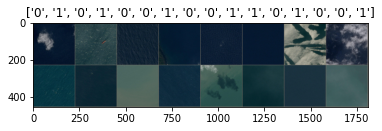

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Obtaining augmented images to put on the report

In [ ]:
from zipfile import ZipFile 
file_name = "Example.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# custom data augmentation
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Sometimes(0.5,
                        iaa.Affine(rotate=(-20, 20), mode='symmetric')),             
        iaa.Sometimes(0.3,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.95)])),
    ])
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [ ]:
# transformation list
transform_list1 = [
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(hue=.05, saturation=.05)
]

transform_list2 =[
    transforms.RandomVerticalFlip(p=1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 3.0)),
    transforms.RandomRotation(degrees = 20), #(20, resample=PIL.Image.BILINEAR),
]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #torchvision.transforms.RandomChoice(transform_list1),
        #torchvision.transforms.RandomChoice(transform_list2),
        ImgAugTransform(),
        lambda x: PIL.Image.fromarray(x),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "Example"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes

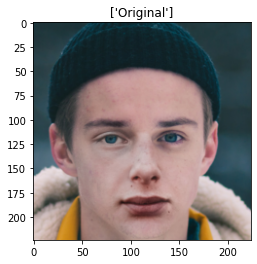

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Training via Transfer Learning 


*   Early stoppage
*   Automatic adjustment in learning rate
*   Try different data augmentation techniques

## Model definition

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    liveloss = PlotLosses()
    tra_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    es = 0

    for epoch in range(num_epochs):
        logs = {}
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        if es > 5:
            print("Early stopping with best_acc: ", best_acc)
            break

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Record training accuracy over epoch
            if phase == 'train':
                tra_acc_history.append(epoch_acc)
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                es = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                es += 1
                print("Counter {} of 5".format(es))

            prefix = ''   
            if phase == 'val':    
                prefix = 'val_'
                val_acc_history.append(epoch_acc)

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
      
        liveloss.update(logs)
        liveloss.send()
    
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Fine-tuning the entire pre-trained Resnet 18 network with the target dataset

In [31]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))

#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.fc = nn.Sequential(
          nn.Linear(num_ftrs , 32),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(32, 2),
          nn.LogSoftmax(dim=1)
)

# Loading the parameters from previous training HERE 
#model_ft.load_state_dict(state_dict)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

512


### Train and evaluate

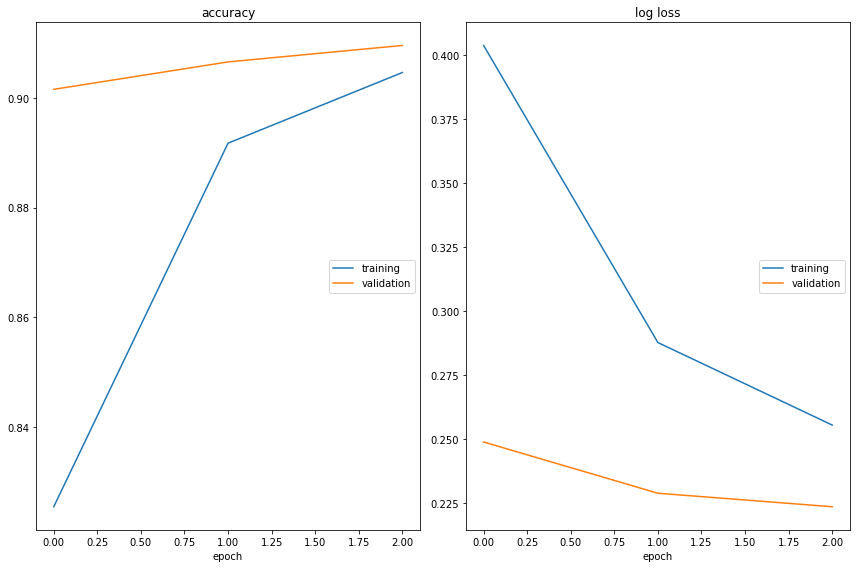

accuracy
	training         	 (min:    0.825, max:    0.905, cur:    0.905)
	validation       	 (min:    0.902, max:    0.910, cur:    0.910)
log loss
	training         	 (min:    0.255, max:    0.404, cur:    0.255)
	validation       	 (min:    0.223, max:    0.249, cur:    0.223)

Epoch 3/19
----------


KeyboardInterrupt: ignored

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

## Fine-tuning ONLY the final layer

In [24]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Sequential(
          nn.Linear(num_ftrs , 32),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(32, 2),
          nn.LogSoftmax(dim=1)
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate (ONLY the final layer)


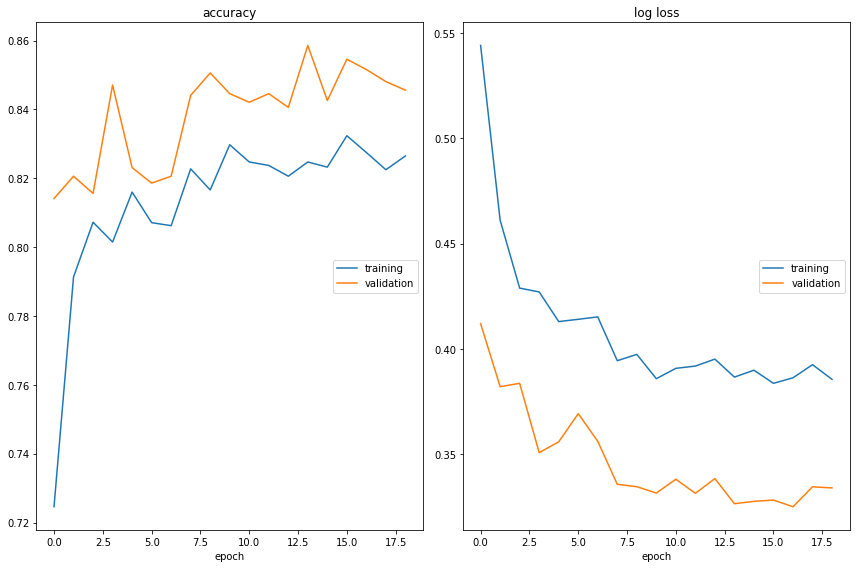

accuracy
	training         	 (min:    0.725, max:    0.832, cur:    0.826)
	validation       	 (min:    0.814, max:    0.859, cur:    0.846)
log loss
	training         	 (min:    0.384, max:    0.544, cur:    0.386)
	validation       	 (min:    0.325, max:    0.412, cur:    0.334)

Epoch 19/24
----------
Early stopping with best_acc:  tensor(0.8586, device='cuda:0', dtype=torch.float64)
Training complete in 35m 55s
Best val Acc: 0.858571


In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

## Saving hyperparameters for later use

In [ ]:
from google.colab import files
torch.save(model_conv.state_dict(), 'resnet18_freeze.pth')

# download checkpoint file
files.download('resnet18_freeze.pth')

NameError: ignored

## Model Prediction Visualization

In [ ]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.set_ylabel('true: {}'.format(class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Visualize the model prediction with true values

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

NameError: ignored

https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html?highlight=sometimes#imgaug.augmenters.meta.Sometimes